In [1]:
# Fit Forward, 3 day gap

In [2]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import random

In [3]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    else:
        thedir = maindir
    return (thedir)

In [4]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [5]:
def read_river_Theodosia(set_primary=False):
    if set_primary:
        nameit = 'Primary River Flow'
    else:
        nameit = 'Secondary River Flow'
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia[nameit] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia[nameit] = theodosia[nameit].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [6]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [7]:
gap_length = 3

In [8]:
def estimate(primary_river, spoint, point, gap_length, ax, fittedbad, fittype, doplots=True):
    goback = 7
    bad = False
    fitlength = np.array([7, 14, 21, 28])
    ratio = np.zeros(len(fitlength))
    fitted = np.zeros(len(fitlength))
    persist = np.zeros((goback))
    linear = np.zeros((goback-1))
    cubic = np.zeros((goback-2))
    for ii in range(1, 8):
        jj = ii + gap_length - 1
        if len(primary_river.iloc[spoint-8:spoint]) != 8:
            print (len(primary_river.iloc[spoint-8:spoint]), primary_river.iloc[spoint])
        persist[ii-1] = primary_river.iloc[spoint-ii:spoint].mean()
        if ii > 1:
            b, m = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 1)
            linear[ii-2] = b + m * jj
        if ii > 2:
            b, m, c = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 2)
            cubic[ii-3] = b + m * jj + c * jj**2
    if fittype == 'fit':
        useriver = matching_dictionary[river]
    elif fittype == 'backup':
        useriver = backup_dictionary[river]
    firstchoice = read_river(useriver, 'primary')
    for jj, length in enumerate(fitlength):
        for ii in range(length):
            denom = firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values
            if len(denom) == 1:
                ratio[jj] = ratio[jj] + (primary_river.iloc[spoint-ii].values /
                            firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values)
            else:
                bad = True
        if not bad:
            fitted[jj] = ratio[jj]/length * firstchoice[firstchoice.index == primary_river.index[point]].values
    if bad:
        fittedbad = fittedbad + 1
    if doplots:
        ax.plot(persist)
        ax.plot(range(1, 7), linear)
        ax.plot(range(2, 7), cubic)
        if not bad:
            ax.plot(fitted)
        ax.plot(primary_river.iloc[spoint-7:spoint].values, 'o')
        ax.plot(7, primary_river.iloc[spoint].values, 'x')
        ax.plot(7+gap_length, primary_river.iloc[point].values, 's')
        ax.grid()
    return (persist, linear, cubic, fitted, bad, fittedbad)

In [9]:
def pmhalf(test, value):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt/value < 0.5 or tt/value > 2:
            bads[ii] = True
    return bads

In [10]:
def inbounds(test, maximum, minimum):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt < minimum or tt > maximum:
            bads[ii] = True
    return bads

In [11]:
def docheck(primary_river, point, persist, linear, cubic, fitted, badfit, ax, doplots=True):
    maximum = primary_river['Primary River Flow'].max()
    minimum = primary_river['Primary River Flow'].min()
    value = primary_river.iloc[point].values
    goodness_persist = np.abs(persist - value)
    goodness_linear = np.abs(linear - value)
    goodness_cubic = np.abs(cubic - value)
    if not badfit:
        goodness_fit = np.abs(fitted - value)
        pmfitted = pmhalf(fitted, value)
        ibfitted = inbounds(fitted, maximum, minimum)
    else:
        goodness_fit = np.zeros((4))
        pmfitted = np.zeros((4))
        ibfitted = np.zeros((4))
    if doplots:
        ax.plot(goodness_persist, 'o')
        ax.plot(goodness_linear, 'o')
        ax.plot(goodness_cubic, 'o')
        if not badfit:
            ax.plot(goodness_fit, 'o')
        ax.grid()
    return (np.concatenate((goodness_persist, goodness_linear, goodness_cubic, goodness_fit)), 
            np.concatenate((pmhalf(persist, value), pmhalf(linear, value), pmhalf(cubic, value), pmfitted)),
            np.concatenate((inbounds(persist, maximum, minimum), inbounds(linear, maximum, minimum), 
                            inbounds(cubic, maximum, minimum), ibfitted)))

In [12]:
def doone(primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, fittype, doplots=True):

    point = random.randrange(len(primary_river.index))
    spoint = point - gap_length + 1
    
    if doplots:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        primary_river.iloc[point-10:point+1].plot(ax=axs[0], marker='s')
    else:
        axs = [0, 1, 2]

    (persist, linear, cubic, fitted, badfit, fittedbad) = estimate(
        primary_river, spoint, point, gap_length, axs[1], fittedbad, fittype, doplots)

    GG, CC, BB = docheck(primary_river, point, persist, linear, cubic, fitted, badfit, axs[2], doplots)
    accumulateG += GG
    accumulateC += CC
    accumulateB += BB
    
    
    return accumulateG, accumulateC, accumulateB, fittedbad

In [13]:
print (gap_length)

3


In [20]:
river = 'Englishman'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  912.  912.  912.  912.] [ 8.46506131  8.48471911  8.79417928  8.8442731   8.78402051  8.8562976
  8.72898824 18.94870581 16.04372049 15.19415878 14.29323459 14.04576269
 13.47492918 54.12581318 39.17076469 32.98056353 28.08362699 24.96923012
  4.57568437  4.69703029  4.78362194  4.98266421] [0.172      0.204      0.21       0.214      0.222      0.237
 0.245      0.343      0.334      0.341      0.335      0.346
 0.356      0.517      0.462      0.432      0.431      0.422
 0.0877193  0.09100877 0.10855263 0.11732456] [0.    0.    0.    0.    0.    0.    0.    0.102 0.085 0.07  0.074 0.076
 0.075 0.199 0.193 0.178 0.154 0.145 0.    0.    0.    0.   ]


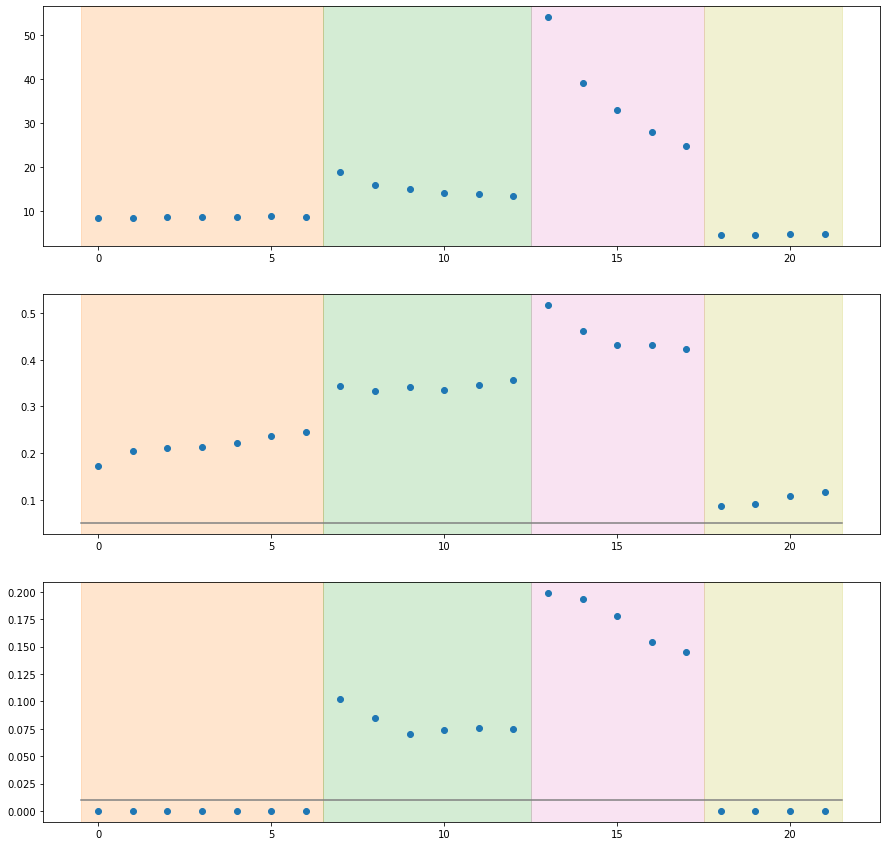

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [22]:
river = 'Homathko_Mouth'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  964.  964.  964.  964.] [ 73.08226166  75.69496307  76.28778355  76.48801241  76.86173354
  77.28692134  77.88587785 124.20816889 119.41571961 117.72497011
 111.17962391 108.60639604 107.3664382  290.24851581 241.70680705
 219.45538568 202.69194209 185.72930187  50.62616335  56.03718598
  59.57235369  63.39232565] [0.043      0.045      0.043      0.047      0.047      0.047
 0.054      0.164      0.169      0.161      0.136      0.136
 0.135      0.346      0.325      0.333      0.318      0.284
 0.03630705 0.04253112 0.0373444  0.04771784] [0.         0.         0.         0.         0.         0.
 0.         0.036      0.035      0.028      0.021      0.013
 0.016      0.142      0.141      0.137      0.119      0.102
 0.         0.         0.         0.00103734]


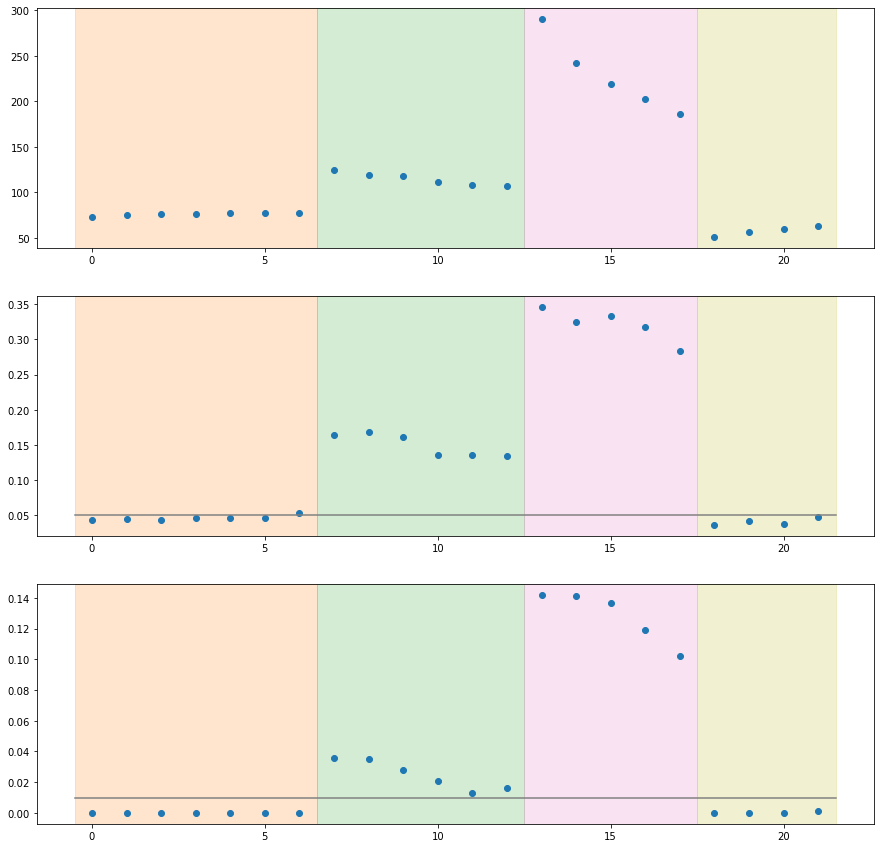

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [25]:
river = 'Salmon_Sayward'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

0 Primary River Flow    13.0
Name: 1956-08-08 00:00:00, dtype: float64
0 Primary River Flow    13.0
Name: 1956-08-08 00:00:00, dtype: float64
0 Primary River Flow    13.0
Name: 1956-08-08 00:00:00, dtype: float64
0 Primary River Flow    13.0
Name: 1956-08-08 00:00:00, dtype: float64
0 Primary River Flow    13.0
Name: 1956-08-08 00:00:00, dtype: float64
0 Primary River Flow    13.0
Name: 1956-08-08 00:00:00, dtype: float64
0 Primary River Flow    13.0
Name: 1956-08-08 00:00:00, dtype: float64
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  698.  698.  698.  698.] [ 38.53141853  38.5046644   39.96746916  40.93657217  40.59102371
  40.60316251  40.85449516  88.25352849  76.6912112   67.94071385
  61.37608735  58.45127588  56.98455475 229.37800319 184.32188236
 155.83992435 138.63496228 115.193215    27.34949615  29.26761134
  29.72054595  31.6540828 ] [0.189      0.201      0.214      0.218      0.225      0.239
 0.245      0.

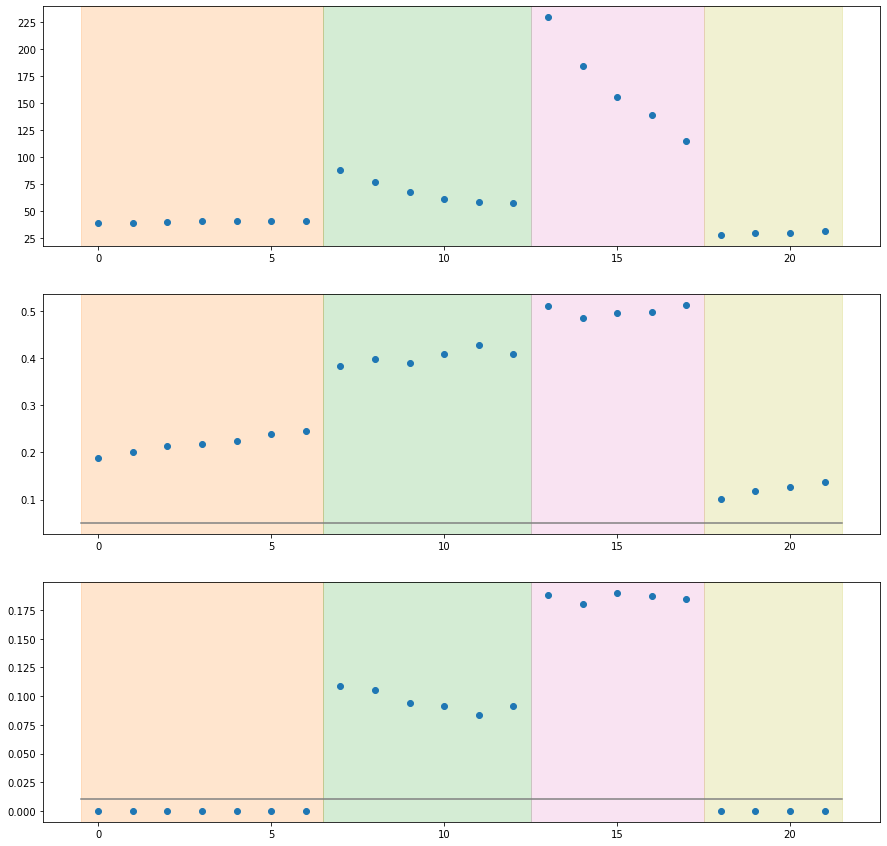

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [27]:
river = 'RobertsCreek'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0

accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  691.  691.  691.  691.] [0.68520191 0.69020256 0.70995291 0.72605819 0.72941434 0.72385357
 0.71742414 1.61922242 1.3920331  1.22887082 1.11040673 1.08977973
 1.05396686 4.98988655 3.33750912 2.8258827  2.43555193 2.10844237
 0.43262897 0.4659342  0.51032939 0.51360491] [0.252      0.272      0.282      0.302      0.321      0.326
 0.332      0.501      0.465      0.457      0.489      0.468
 0.449      0.604      0.596      0.581      0.568      0.564
 0.10853835 0.11577424 0.14182344 0.14761216] [0.         0.         0.         0.         0.         0.
 0.         0.173      0.148      0.137      0.145      0.12
 0.115      0.236      0.247      0.221      0.223      0.236
 0.00144718 0.00144718 0.00289436 0.00144718]


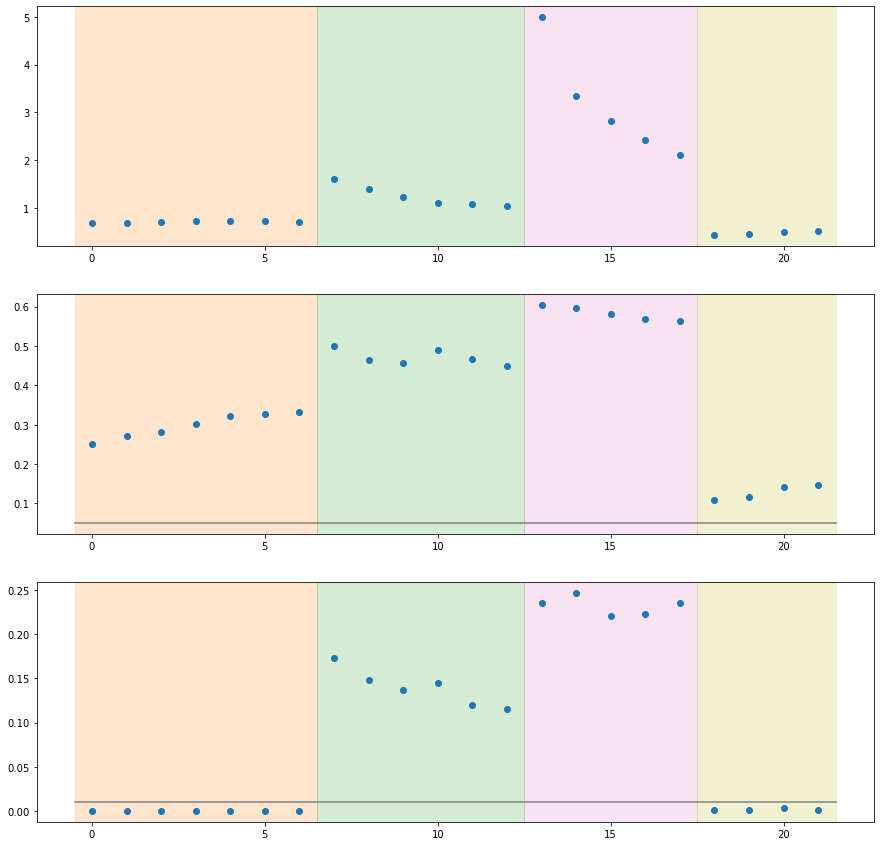

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [29]:
print (gap_length)

3


In [42]:
river = 'Squamish_Brackendale'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  862.  862.  862.  862.] [ 78.07086093  79.80879628  79.37524783  79.84327057  81.10895533
  81.77911414  82.11206352 159.51222323 144.29047847 139.40657776
 127.30694506 124.26629754 118.30059951 446.40429175 319.32832314
 279.09528941 257.29373072 233.95187568  46.30564725  50.12848173
  53.09878769  56.64758163] [0.106      0.107      0.109      0.113      0.112      0.118
 0.131      0.324      0.316      0.318      0.307      0.303
 0.288      0.542      0.524      0.458      0.467      0.485
 0.0324826  0.03944316 0.04756381 0.05104408] [0.    0.    0.    0.    0.    0.    0.    0.087 0.059 0.058 0.042 0.051
 0.043 0.23  0.205 0.17  0.163 0.161 0.    0.    0.    0.   ]


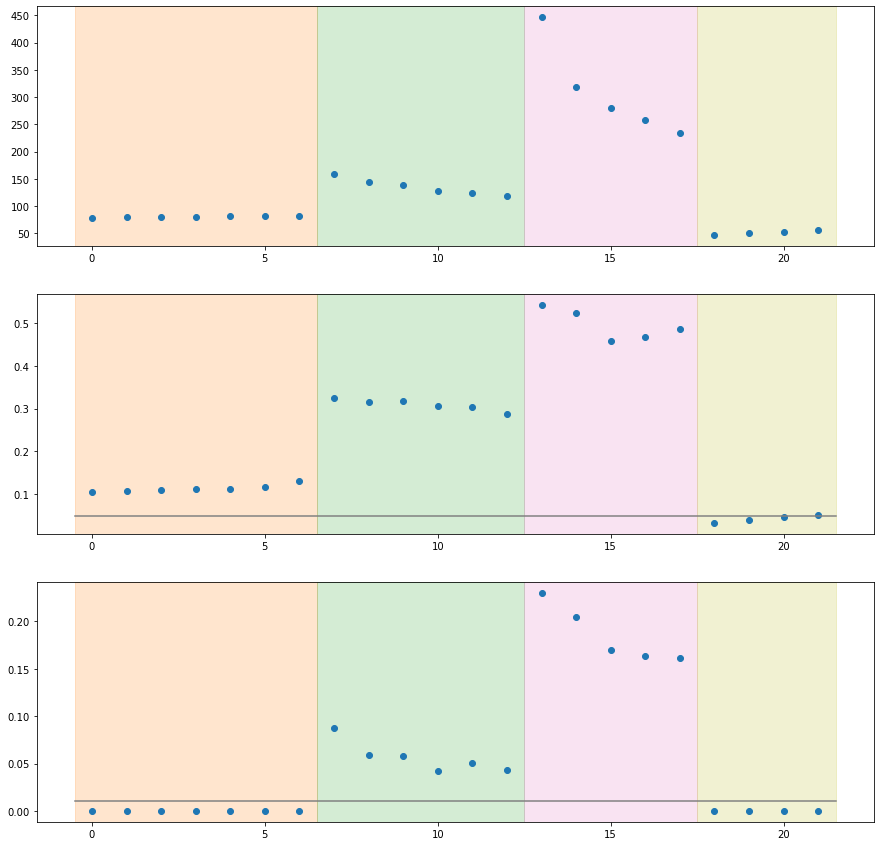

In [43]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [37]:
river = 'SanJuan_PortRenfrew'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  656.  656.  656.  656.] [ 34.77687859  34.90499469  36.01887015  37.24665793  38.0246665
  38.30175855  38.12302156  76.9755045   66.7759944   61.5791508
  57.21518716  54.16801017  53.58639004 211.12169928 160.51805343
 140.10944007 123.77781326 108.86045359  16.93411025  17.40028084
  18.96697885  19.17675702] [0.243      0.263      0.28       0.293      0.312      0.321
 0.324      0.452      0.458      0.451      0.458      0.443
 0.45       0.541      0.524      0.522      0.522      0.54
 0.07621951 0.11432927 0.11585366 0.13567073] [0.         0.         0.         0.         0.         0.
 0.         0.156      0.133      0.123      0.112      0.117
 0.111      0.219      0.214      0.197      0.203      0.212
 0.00152439 0.         0.00152439 0.00152439]


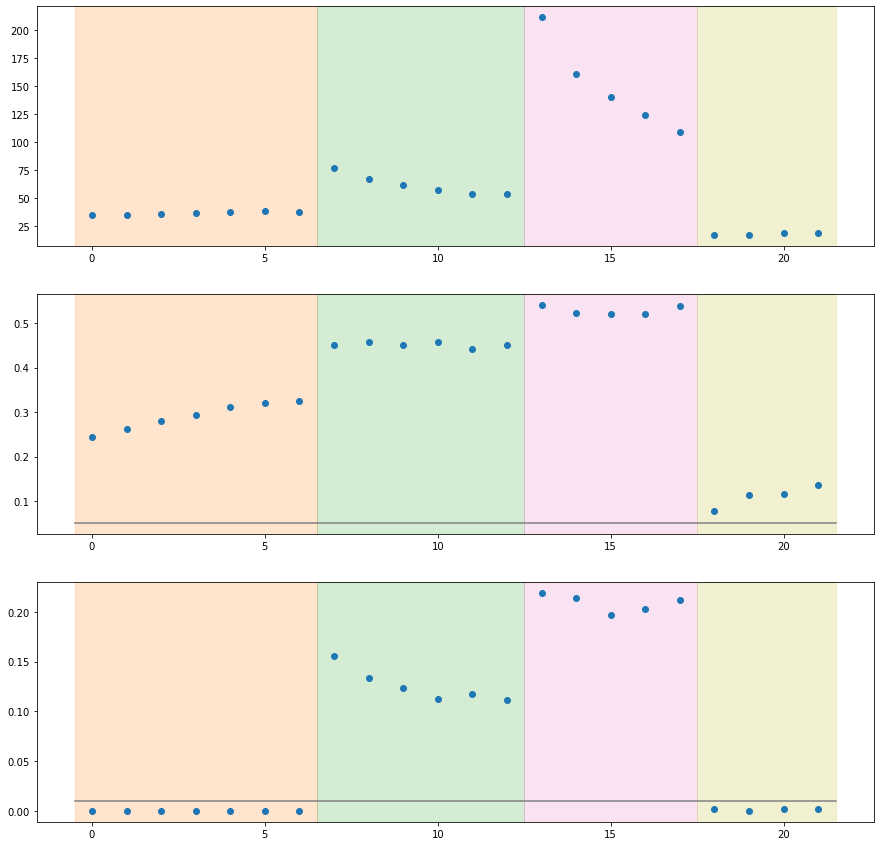

In [38]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [39]:
river = 'SanJuan_PortRenfrew'
# use backup River
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,
        accumulateG, accumulateC, accumulateB, fittedbad, 'backup', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  984.  984.  984.  984.] [ 38.28456415  40.08786589  39.39267593  39.21757924  39.58112514
  39.59900902  39.83127061  87.45382642  75.42718191  71.67372393
  66.35692089  63.28019262  59.64173405 257.48665245 184.56710837
 156.90536745 132.02089289 121.7453357   25.56612107  26.3751394
  25.68952388  26.09604109] [0.237      0.262      0.27       0.299      0.316      0.314
 0.331      0.454      0.449      0.473      0.462      0.454
 0.463      0.555      0.545      0.542      0.545      0.558
 0.12296748 0.1351626  0.14735772 0.15752033] [0.         0.         0.         0.         0.         0.
 0.         0.14       0.13       0.14       0.132      0.122
 0.113      0.224      0.22       0.206      0.219      0.212
 0.00203252 0.00203252 0.00304878 0.00304878]


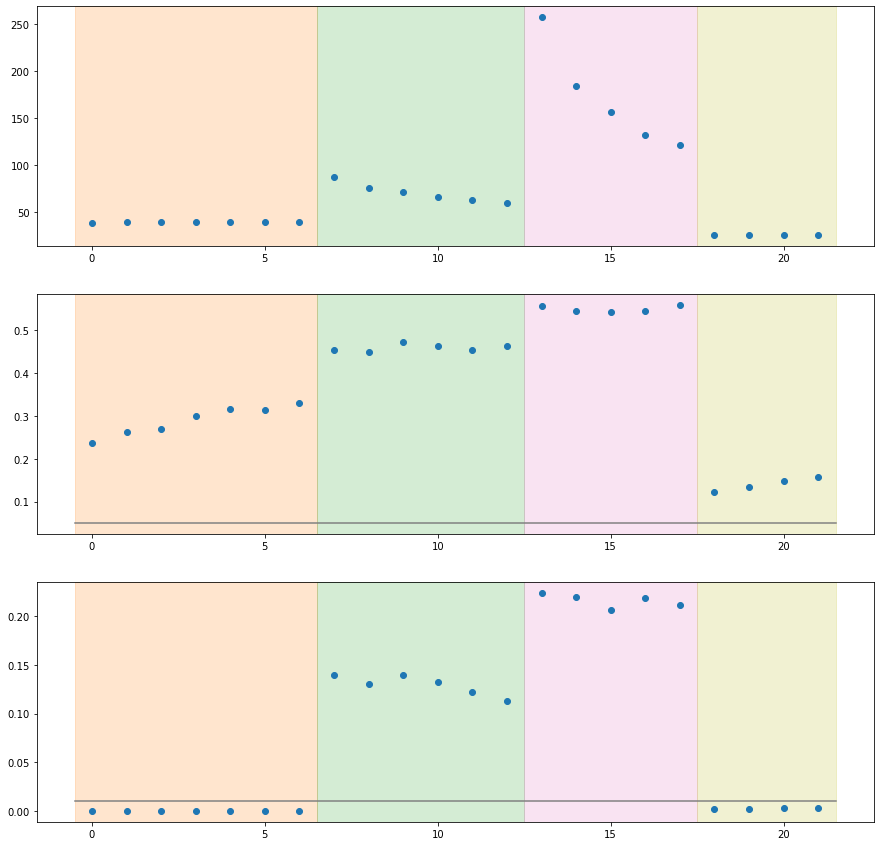

In [40]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [45]:
river = 'Snohomish_Monroe'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 1970-01-08 00:00:00, dtype: float64
0 Primary River Flow    99.1088
Name: 

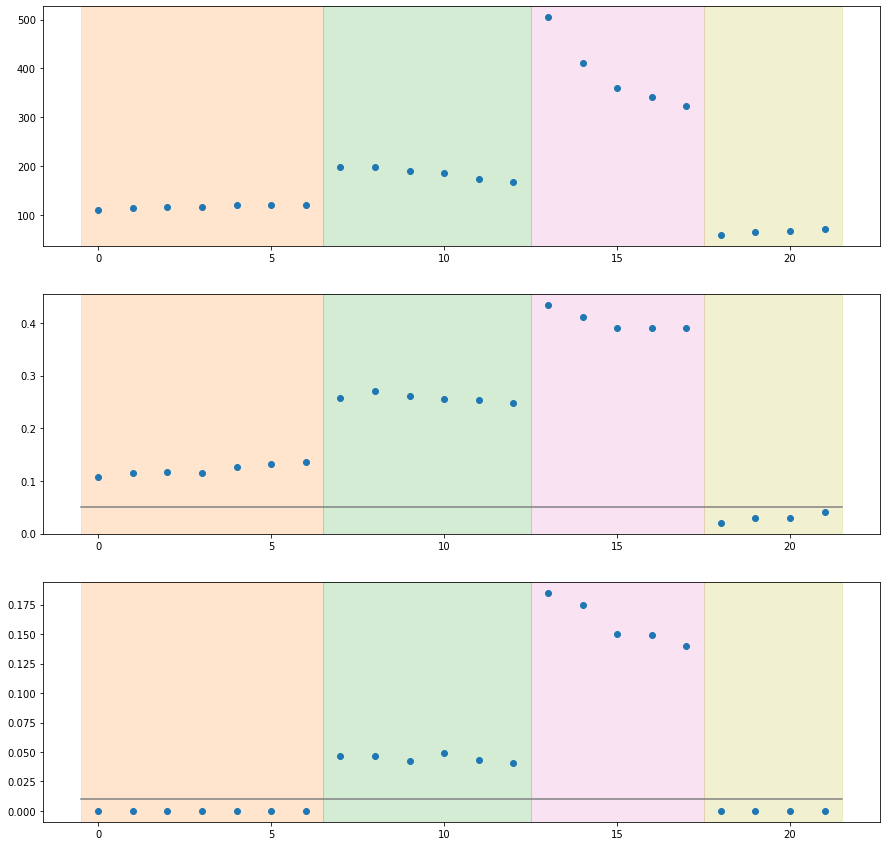

In [46]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [47]:
river = 'Skagit_MountVernon'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  999.  999.  999.  999.] [120.5717966  126.3556476  129.4498737  130.91168118 130.3344703
 129.9844475  129.94470187 217.2314714  206.0721099  200.94923474
 193.3087411  188.68608538 187.41105686 561.8424204  452.09935167
 405.60801517 359.86588573 332.77442796 121.49208839 133.80146719
 144.87346646 152.57449224] [0.033      0.042      0.043      0.046      0.046      0.047
 0.047      0.183      0.166      0.144      0.128      0.119
 0.117      0.474      0.384      0.357      0.325      0.302
 0.03303303 0.03903904 0.04404404 0.04604605] [0.       0.       0.       0.       0.       0.       0.       0.053
 0.045    0.035    0.027    0.016    0.014    0.255    0.181    0.174
 0.161    0.144    0.002002 0.003003 0.003003 0.002002]


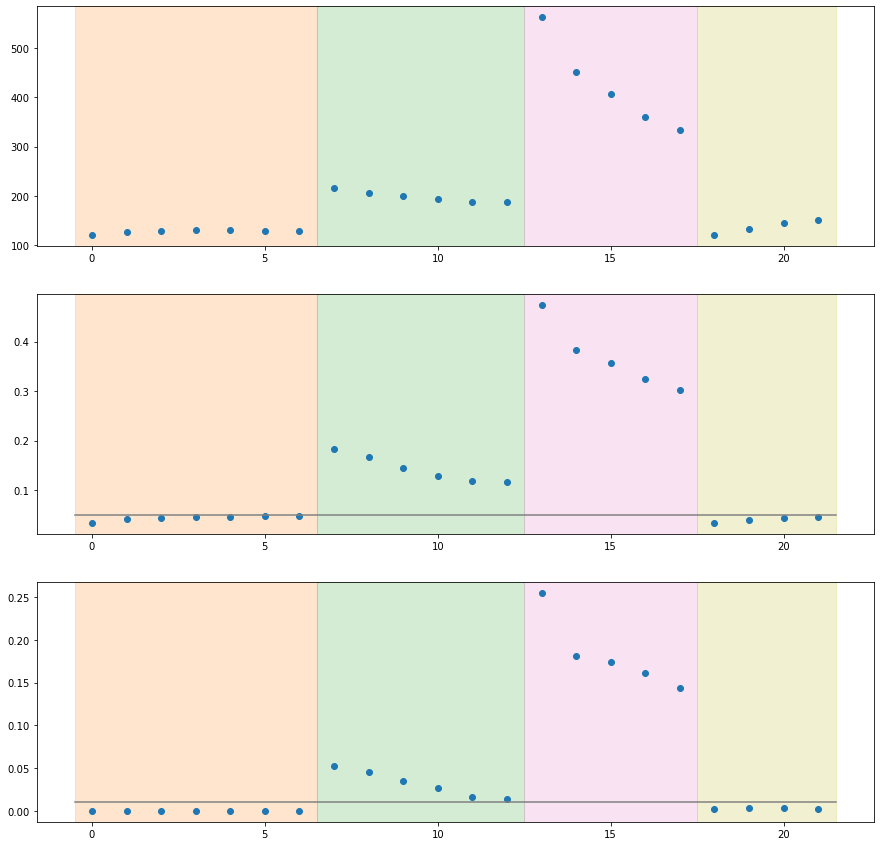

In [48]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [49]:
river = 'Nisqually_McKenna'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  998.  998.  998.  998.] [10.08293296 10.4566864  10.5782503  10.61448171 10.75893426 11.11101686
 11.43188048 16.55394399 17.36125613 16.85238074 16.61356817 16.56106743
 16.41335791 38.11837998 32.62374741 31.97265539 29.08272512 28.01209738
 13.10714368 14.4575049  15.86173761 17.1776169 ] [0.048      0.049      0.053      0.054      0.057      0.06
 0.063      0.129      0.12       0.118      0.129      0.13
 0.137      0.27       0.259      0.243      0.233      0.211
 0.0751503  0.09418838 0.11823647 0.14128257] [0.    0.    0.    0.    0.    0.    0.    0.03  0.025 0.026 0.024 0.026
 0.023 0.103 0.086 0.085 0.076 0.072 0.    0.    0.    0.   ]


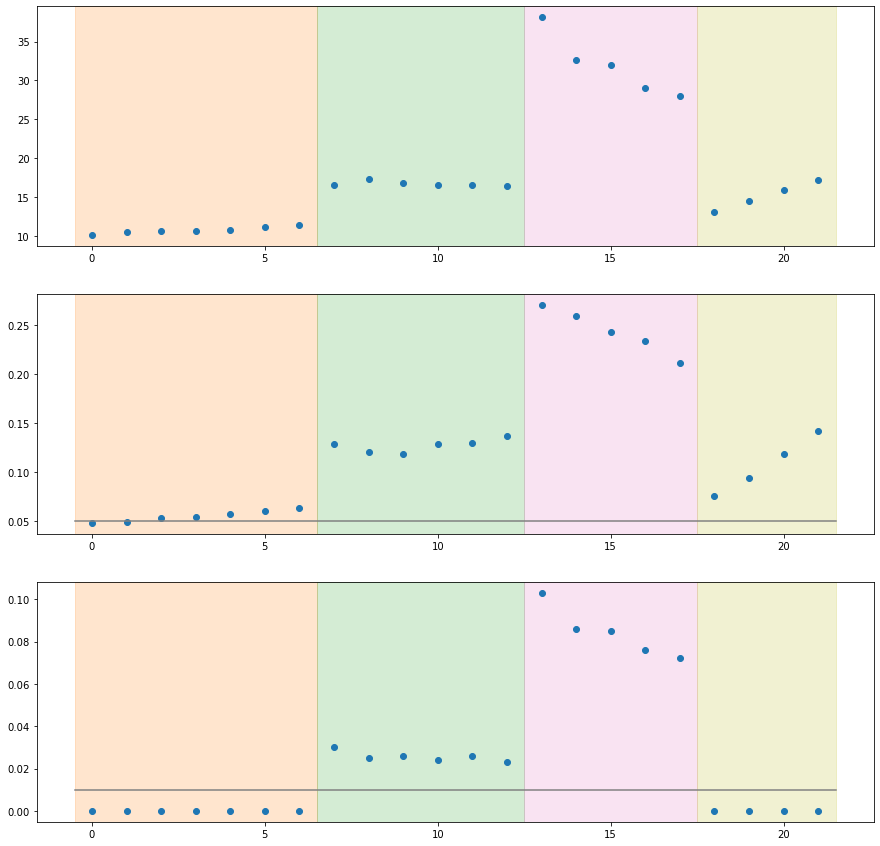

In [50]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [52]:
river = 'Greenwater_Greenwater'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.] [1.49888187 1.64880089 1.74487277 1.79646244 1.83846775 1.89983461
 1.96021801 2.35254578 2.27082894 2.30336691 2.37353768 2.40420274
 2.35172821 5.27486258 4.62613564 4.33771899 4.03608149 3.8250792
 1.13003776 1.23785301 1.30516479 1.36820613] [0.041 0.046 0.046 0.055 0.061 0.061 0.068 0.088 0.091 0.1   0.097 0.103
 0.109 0.22  0.193 0.194 0.198 0.188 0.034 0.044 0.046 0.05 ] [0.    0.    0.    0.    0.    0.    0.    0.012 0.013 0.015 0.016 0.015
 0.018 0.083 0.074 0.069 0.061 0.063 0.001 0.002 0.002 0.002]


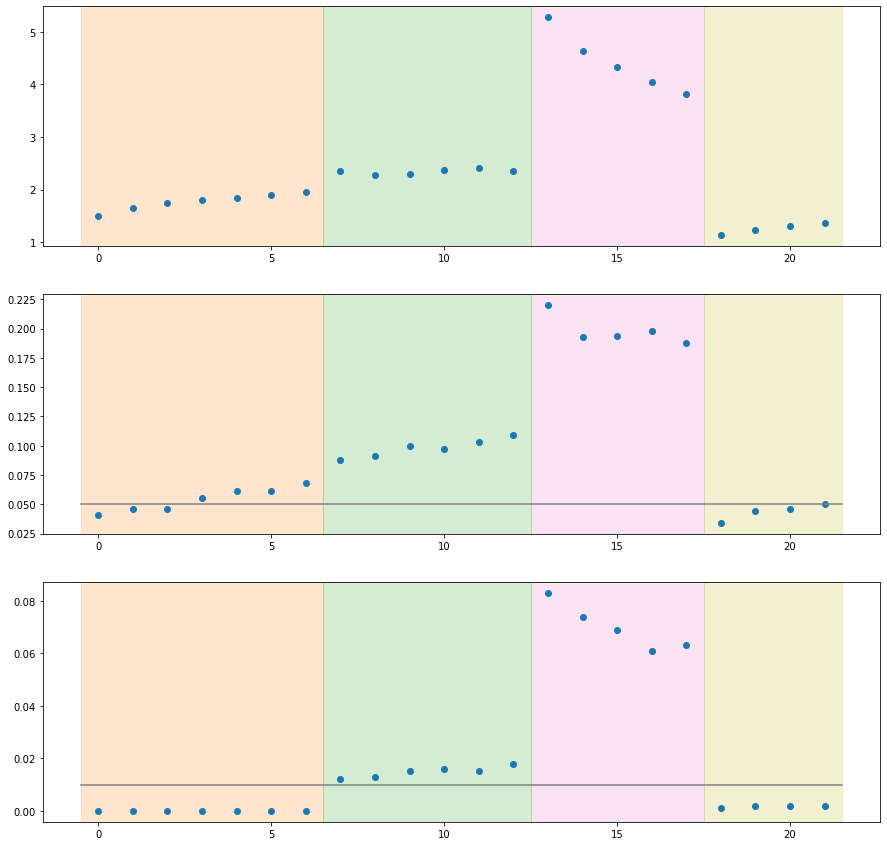

In [53]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [56]:
river = 'Clowhom_ClowhomLake'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  783.  783.  783.  783.] [ 7.55334948  7.76507219  7.88019992  7.93042769  7.98033133  8.10630376
  8.1443171  14.94201976 13.50622251 12.76471189 12.27164183 12.11484301
 11.68877998 40.51951334 32.50065795 27.13767816 24.82204246 22.43844401
  7.36017893  8.24243673  9.08031509  9.61330464] [0.174      0.186      0.207      0.21       0.228      0.233
 0.248      0.389      0.404      0.389      0.399      0.389
 0.38       0.556      0.558      0.551      0.558      0.546
 0.100894   0.12005109 0.1366539  0.14559387] [0.         0.         0.         0.         0.         0.
 0.         0.114      0.108      0.101      0.113      0.116
 0.1        0.246      0.236      0.22       0.211      0.225
 0.00383142 0.00510856 0.00766284 0.0063857 ]


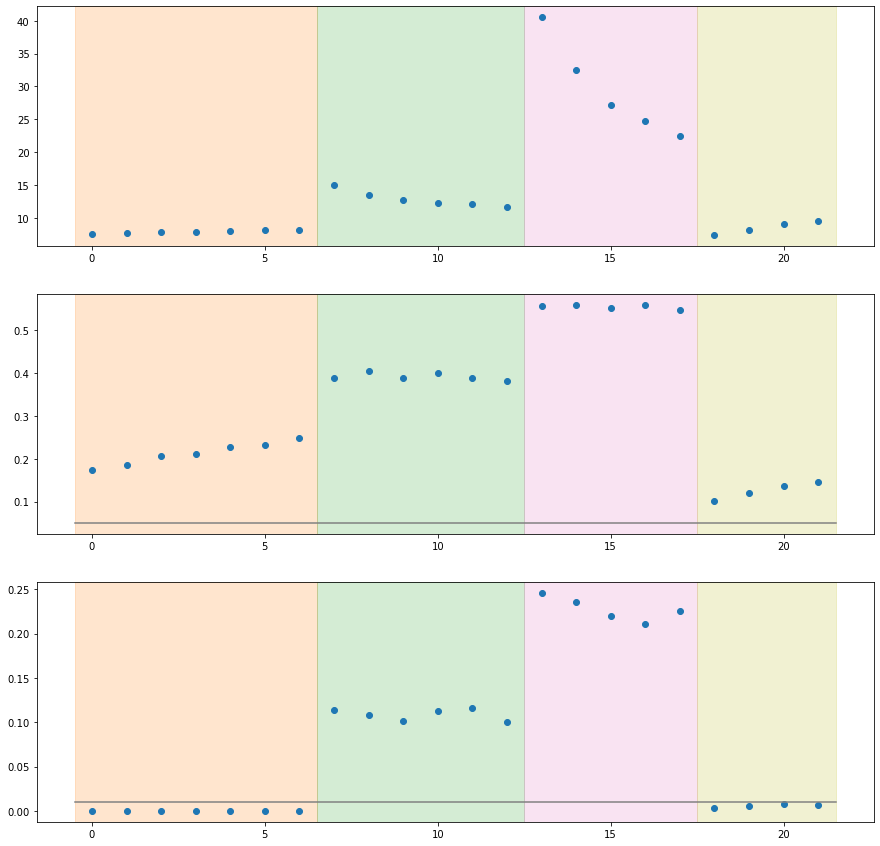

In [57]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [61]:
river = 'Theodosia'

primary_river = read_river_Theodosia(set_primary=True)
primary_river = primary_river.drop(['Diversion_x', 'Bypass', 'Scotty', 'Diversion_y', 
                                   'FlowFromDiversion'], axis=1)

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.] [ 5.43986036  5.48851989  5.64370144  5.80589466  5.8675911   6.00738365
  6.07270692 12.51747547 10.94323006 10.26840275  9.36630598  9.17041404
  9.04275198 35.90608384 29.50215671 23.18350205 21.21667663 18.34093314
  2.92523116  2.97302958  3.10123327  3.20994751] [0.274 0.292 0.303 0.329 0.342 0.349 0.359 0.53  0.541 0.542 0.524 0.523
 0.509 0.649 0.664 0.647 0.632 0.622 0.084 0.085 0.105 0.132] [0.    0.    0.    0.    0.    0.    0.    0.169 0.169 0.152 0.148 0.152
 0.159 0.249 0.267 0.263 0.254 0.243 0.001 0.    0.    0.   ]


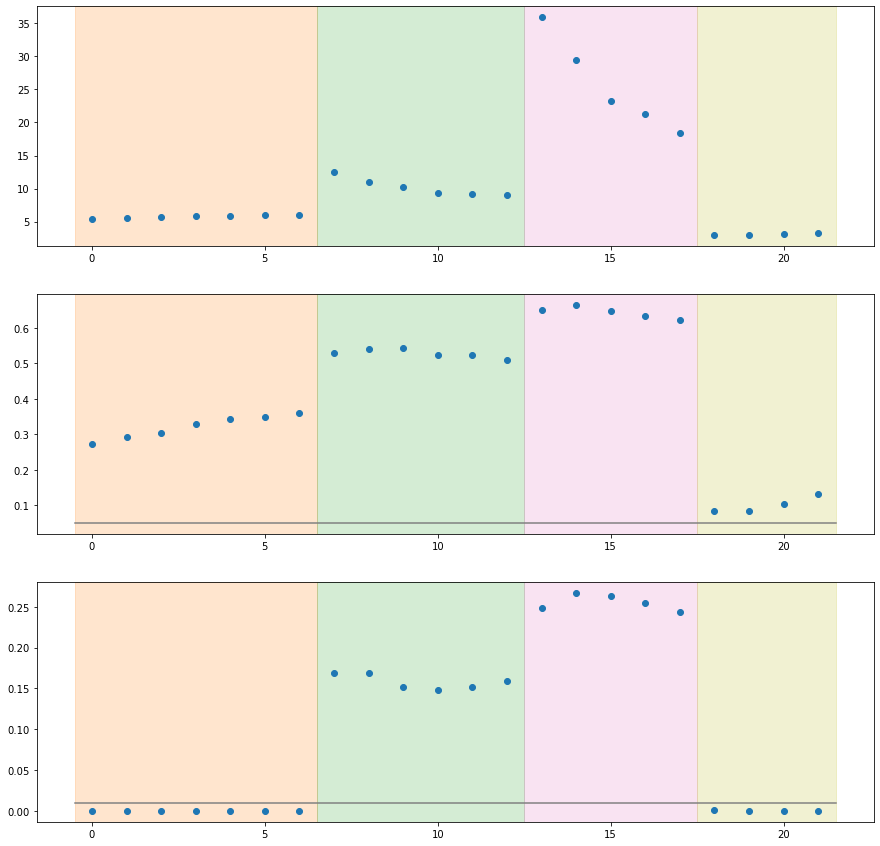

In [62]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [67]:
river = 'Theodosia'

# Try Clowhom Lake *****

primary_river = read_river_Theodosia(set_primary=True)
primary_river = primary_river.drop(['Diversion_x', 'Bypass', 'Scotty', 'Diversion_y', 
                                   'FlowFromDiversion'], axis=1)

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'backup', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  969.  969.  969.  969.] [ 6.18026239  6.0598279   5.96902729  5.90383164  5.96084558  6.03317315
  6.10751427 14.77473554 12.03945052 10.58340913  9.57396208  8.85725782
  8.64637285 41.62867332 30.96124195 24.04252417 20.01067052 17.89976224
  4.39985632  5.21117535  4.98350575  5.35969058] [0.291      0.309      0.328      0.34       0.341      0.344
 0.349      0.544      0.571      0.551      0.544      0.541
 0.515      0.667      0.676      0.675      0.663      0.665
 0.15995872 0.18575851 0.22291022 0.28379773] [0.         0.         0.         0.         0.         0.
 0.         0.182      0.149      0.139      0.117      0.117
 0.125      0.264      0.256      0.264      0.246      0.232
 0.00309598 0.00412797 0.00206398 0.00309598]


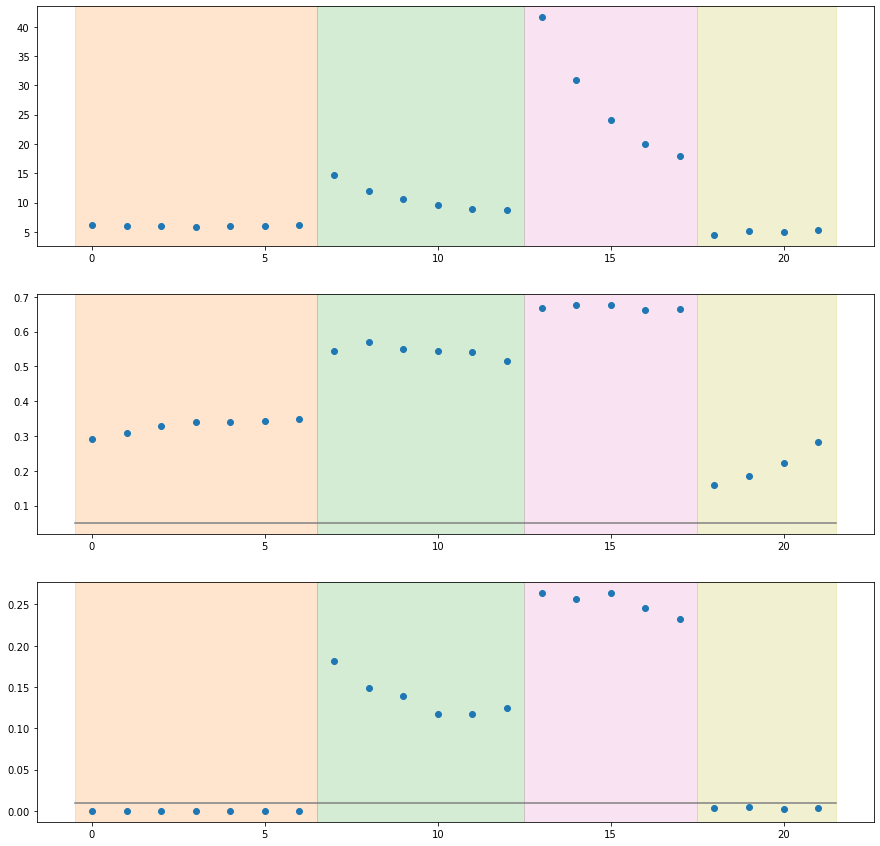

In [68]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');